Sometimes we may want to understand the behavior of parameters we seek to analyze. For example, the proportion of students that pass or fail a particular class or the proportion of voters who support a particular candidate. A useful approach is to simulate the behavior of this proportion parameter and make inferences about its distribution. The following example illustrates how we can use Markov Chains to learn about a parameter's distribution.

Import the required python modules:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
%matplotlib inline

Lets generate some hypothetical data that represents the outcome fail = 1, pass = 0, in a given college class. The data then consists of 100 samples generated by a bernoulli process with $p=0.2$. 

In [8]:
x = np.random.binomial(1,.2,100)

print x
print np.mean(x)

[0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1]
0.19


### Bayesian Inference and Estimation

To generate a Markov chain using the Metropolis sampler consider the model where the data follows a Bernoulli process and the parameter is given by the beta cojugate prior:

$$ X_i\ |\ \theta \sim iid\ binomial,\ b(1,\theta) $$

$$ \Theta \sim beta(\alpha,\beta)$$

Here the conditional likelihood proportional to the following expression:

$$L(\theta\ |\ X) \propto \theta^{\alpha-1}(1-\theta)^{\beta-1}$$

with $\alpha = 1 + \sum_{i=1}^n x_i$ and $\beta = n + 1 - \sum_{i=1}^n x_i$. Thus, the likelihood function is really proportional to the binomial pmf:

$$L(\theta\ |\ X)\propto\theta^{\sum x_i}(1-\theta)^{n-\sum x_i}$$


For details on the derivation of conjugate families <a href="https://en.wikipedia.org/wiki/Conjugate_prior" target="_blank">see this article</a>.

**Metropolis Sampler**

With the Metropolis sampler we accept a point $\Theta_t=Y$ with probability:

$$\alpha\left(\Theta,Y\right) = min\left\{1,\dfrac{L(y)}{L(\theta_{t-1})}\right\}$$

Here $Y$ has the prior $Unif(0,1)$ as its distribution. Thus at each step $t$ we draw a $y_t$ and a $u_t \sim Unif(0,1)$, and calculate $\alpha\left(\Theta,Y\right)$. If $u_t \leq \alpha\left(\theta_{t-1},y_t\right)$ we set $\theta_t = y_t$ else $\theta_t = \theta_{t-1}$

** Random Walk Metropolis Sampler**

We can modify the above process by setting: 
$$y_t = \theta_{t-1} + \dfrac{z}{\sqrt{12}}$$
where
$$z_t = a + (b - a)u_t, \quad a = -0.5, \quad b = 0.5, \quad and \quad u_t \sim Unif(0,1).$$

The code to implement this method is relatively simple:

Define the likelihood function:

In [9]:
def binom_likelihood(x,theta):
    n = len(x)
    return theta**np.sum(x) * (1-theta)**(n-np.sum(x))

Write a script that generates the Markov chains and plots the results:

In [10]:
@jit
def metropolis(data,m,sampler = 'met'):
    # first we initialize the chain:
    n = len(data)
    mc = np.zeros(m)
    mc[0] = np.random.rand()
    
    # Then iterate through the length of the chain and transititon from state to state until convergence.
    # Generate m samples in the chain
    for i in xrange(1,m):
        if sampler == 'random':
            a,b = -0.5,0.5
            z = a + (b-a)*np.random.uniform()
            y = mc[i-1] + z/float(np.sqrt(12))
        elif sampler == 'met':
            y = np.random.uniform()
        u = np.random.rand()
        alphaf = min(1, binom_likelihood(x,y)/float(binom_likelihood(x,mc[i-1])))
        if u <= alphaf:
            mc[i] = y
        else:
            mc[i] = mc[i-1]
    # The first 5% of the observations are "burnt" as a measure to get rid of simulations that are 
    # outside of the conversion range.
    burn = 0.05
    mc = mc[int(burn*m):m]
    
    # Now we plot the results and calculate the mean and standard deviation of the chain:
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(20,5)
    ax[0].plot(mc)
    if sampler == 'met':
        ax[0].set_title(r'Metropolis Chain')
    elif sampler == 'random':
        ax[0].set_title(r'Random Walk Chain')

    sns.distplot(mc, ax = ax[1])
    mc_mu = np.mean(mc) 
    mc_sigma = np.std(mc)
    textstr = '$\mu=%.2f$\n$\sigma=%.2f$'%(mc_mu, mc_sigma)

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=14,
               verticalalignment='top', bbox=props)

    ax[1].set_title(r'$\theta$ Parameter Density Estimation')
    plt.show()
    
    # output
    return mc

Below we obtain a Markov chain that simulates the distribution of $\Theta$ using the standard Metropolis sampler:

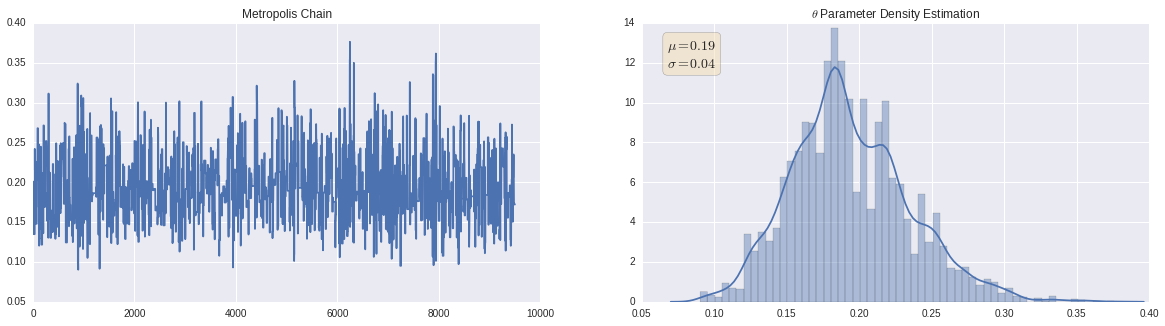

In [11]:
mcmc1 = metropolis(x,10000,'met')

We can also obtain a similar Markov chain for $\Theta$ using the random walk sampler:

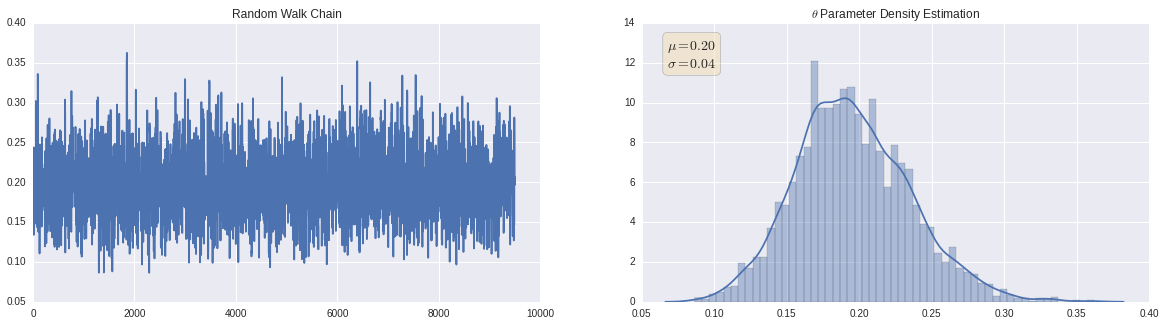

In [12]:
mcmc2 = metropolis(x,10000,'random')

The resulting chains can now be used to make statistical statements about the proportion parameter $\Theta$ such as point estimates and confidence intervals.